In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import datetime
import calendar
from collections import defaultdict
from patsy import dmatrices
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

## Example plot

Linear model trained on all areas but Birmingham, tested on Birmingham.

In [2]:
def plot_linear_model(actual_report, predictions, start_date, end_date, name = 'flow model'):
    predictions = predictions[predictions.timestamp.between(start_date, end_date)]
    actual_report = actual_report[actual_report.timestamp.between(start_date, end_date)]
        
    fig, ax = plt.subplots(figsize=(15,3))
    predictions.plot('timestamp','total_volume_normalised_predictions', ax=ax, kind = 'line', alpha=1, c='red')
    actual_report.plot('timestamp','total_volume_normalised', ax=ax, kind = 'scatter', alpha=0.25, c='black')
    
    plt.ylabel(f'Normalised Traffic Count')
    plt.xlabel(f'Day of Month')
    ax.legend(["Predicted Normalised Traffic Count"])
    plt.savefig('flow_model', dpi = 300)

    plt.show()

In [3]:
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_birmingham_report_df_norm')
global_predictions_birmingham = pd.read_feather('linear-flow-model/linear-birmingham')

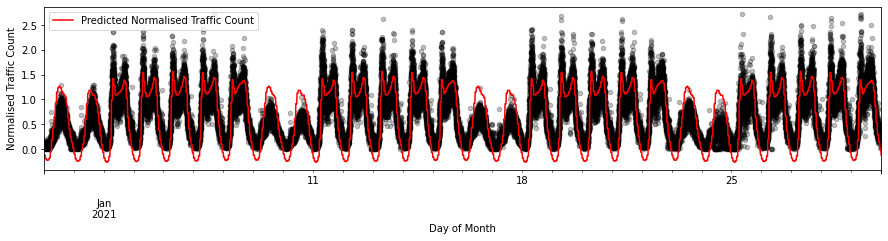

In [4]:
plot_linear_model(clean_birmingham_report_df_norm, 
                  global_predictions_birmingham, 
                  "2021-01-02 00:14:00", 
                  "2021-01-30 00:14:00", 
                  name = 'linear-model-birmingham-Jan')

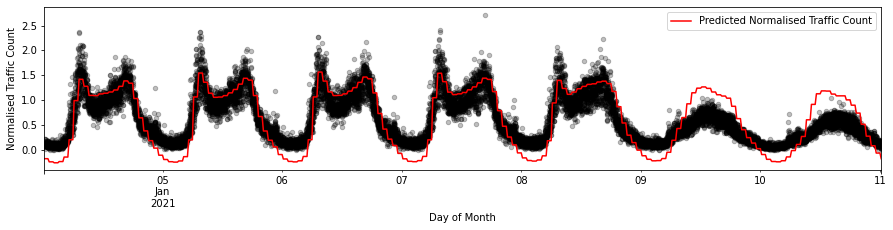

In [5]:
plot_linear_model(clean_birmingham_report_df_norm, 
                  global_predictions_birmingham, 
                  "2021-01-04 00:14:00", 
                  "2021-01-11 00:14:00", 
                  name = 'linear-model-birmingham')

## Predict AADTs

In [5]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/yolov5--Separate-Directions-LiveSpeed-RecallAdjusted')

# Import the reports that have the yearly data for all the sites
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')
image_year_report_manchester = pd.read_feather('image_year_traffic_reports/clean_manc_report_df')
image_year_report_cambridge = pd.read_feather('image_year_traffic_reports/clean_cam_report_df')
image_year_report_thorpe = pd.read_feather('image_year_traffic_reports/clean_thorpe_report_df')
image_year_report_epping = pd.read_feather('image_year_traffic_reports/clean_epping_report_df')
image_year_report_bristol = pd.read_feather('image_year_traffic_reports/clean_bristol_df')

# Import the model predictions

# Global Models
global_model_birmingham = pd.read_feather('linear-flow-model/linear-birmingham')
global_model_manchester = pd.read_feather('linear-flow-model/linear-manchester')
global_model_cambridge = pd.read_feather('linear-flow-model/linear-cambridge')
global_model_thorpe = pd.read_feather('linear-flow-model/linear-thorpe')
global_model_epping = pd.read_feather('linear-flow-model/linear-epping')
global_model_bristol = pd.read_feather('linear-flow-model/linear-bristol')
# Local models
local_model_birmingham = pd.read_feather('linear-flow-model/linear-birmingham-local')
local_model_manchester = pd.read_feather('linear-flow-model/linear-manchester-local')
local_model_cambridge = pd.read_feather('linear-flow-model/linear-cambridge-local')
local_model_thorpe = pd.read_feather('linear-flow-model/linear-thorpe-local')
local_model_epping = pd.read_feather('linear-flow-model/linear-epping-local')
local_model_bristol = pd.read_feather('linear-flow-model/linear-bristol-local')

# Put the Dataframe into dicts so that they can be eaility accessed
image_year_reports = {"birmingham": image_year_report_birmingham,
          "manchester" : image_year_report_manchester,
          "cambridge" : image_year_report_cambridge,
          "thorpe" : image_year_report_thorpe,
          "epping" : image_year_report_epping,
          "bristol" : image_year_report_bristol }

global_models = {"birmingham": global_model_birmingham,
          "manchester" : global_model_manchester,
          "cambridge" : global_model_cambridge,
          "thorpe" : global_model_thorpe,
          "epping" : global_model_epping,
          "bristol" : global_model_bristol }

local_models = {"birmingham": local_model_birmingham,
          "manchester" : local_model_manchester,
          "cambridge" : local_model_cambridge,
          "thorpe" : local_model_thorpe,
          "epping" : local_model_epping,
          "bristol" : local_model_bristol }



# Times of Sattelite Observation
times = {"birmingham": datetime.datetime(2021,6,15,12,14),
          "manchester" : datetime.datetime(2019,4,19,12,59),
          "cambridge" : datetime.datetime(2021,11,2,12,29),
          "thorpe" : datetime.datetime(2022,3,8,12,14),
          "epping" : datetime.datetime(2022,3,8,12,14),
          "bristol" : datetime.datetime(2020,8,8,12,14) }

In [23]:
def model_window_satellite(test_report, time, date_range, traffic_predictions_focus, predictions):
    ''' 
    Function that applies a traffic model to the area test_report and the predictions from traffic_predictions_focus and outputs the results
    '''
    
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []    
    # For each site in the test area estimate the average flow over date_range
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        
        # Calulate N(t) at time time
        N_t = predictions[predictions.timestamp==time].total_volume_normalised_predictions.to_numpy()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/N_t
        
        # Obtain the count values via satellite for site_list
        X_t_sat = traffic_predictions_focus[traffic_predictions_focus.sites == sites_str].all_vehicle_pred.to_numpy()
        # Make a prediction of avg_flow from the satellites counts
        avg_flow_pred_sat = X_t_sat/N_t
        
        if len (avg_flow_pred) == 0:
            print(avg_flow_pred)
            print(X_t, N_t)
            print(time)
            display(predictions)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())
        avg_flow_preds_sat.append(avg_flow_pred_sat.item())
        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    return avg_flows, avg_flow_preds, avg_flow_preds_sat

In [ ]:
def model_window(test_report, time, date_range, predictions):
    ''' 
    Function that applies a traffic model to the area test_report and the predictions from traffic_predictions_focus and outputs the results
    '''
    
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []    
    # For each site in the test area estimate the average flow over date_range
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        
        # Calulate N(t) at time time
        N_t = predictions[predictions.timestamp==time].total_volume_normalised_predictions.to_numpy()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/N_t
        
        if len (avg_flow_pred) == 0:
            print(avg_flow_pred)
            print(X_t, N_t)
            print(time)
            display(predictions)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    
    return avg_flows, avg_flow_preds

In [7]:
def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2


def plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT'):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(x=avg_flow_preds, y=avg_flows, ax=ax)
    # lims of the y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)
    plt.xlabel(f'Predicted {name}')
    plt.ylabel(f'Actual {name}')
    plt.show()

In [8]:
def test_area(area, model, AADT = True):
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    test_report = image_year_reports[area]
    time = times[area]
    if AADT:
        start_str, end_str = year_str(time)
    else:
        start_str, end_str = month_str(time)
        
    date_range = pd.date_range(start_str, end_str, freq="15min")
    return model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)

In [ ]:
def test_area_no_sat(area, model, AADT = True):
    test_report = image_year_reports[area]
    time = times[area]
    if AADT:
        start_str, end_str = year_str(time)
    else:
        start_str, end_str = month_str(time)
        
    date_range = pd.date_range(start_str, end_str, freq="15min")
    return model_window(test_report, time, date_range, model)

## Results on train vs test set

### AADT

In [30]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_train = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol", "manchester"]
for area in areas:
    print(area)
    
    predictions_glocal = global_models[area]
    
    AADT_sat_results[area] = test_area(area, predictions_glocal) # avg_flows, avg_flow_preds, avg_flow_preds_sat
    
    # Get restuls with the same model on the traiing areas
    for other_area in [other_area for other_area in areas if (other_area != area and times[area].year == times[other_area].year)]:
        print(f'train area: {other_area}')
        avg_flows, avg_flow_preds, avg_flow_preds_sat = [], [], []
        
        flows, flow_preds, flow_preds_sat = test_area(other_area, predictions_glocal)
        
        avg_flows += flows
        avg_flow_preds += flow_preds
        avg_flow_preds_sat += flow_preds_sat
        
        AADT_sat_results_train[other_area] = avg_flows, avg_flow_preds, avg_flow_preds_sat

birmingham
train area: cambridge
cambridge
train area: birmingham
bristol
manchester


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  8652.58 		 MSE: 5630.17 		 MSE: 5426.34
MAE:  79.32  		 MAE: 56.79 		 MAE: 56.38
MAPE: 0.36 		 MAPE: 0.17 		 MAPE 0.17
R^2:  0.82 		 R^2: 0.88 		 R^2: 0.89


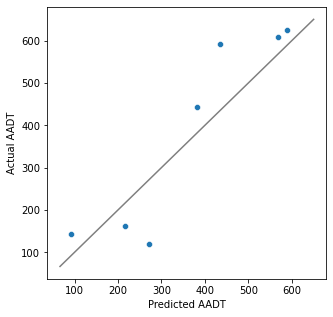

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  14047.89 		 MSE: 588.38 		 MSE: 578.63
MAE:  102.61  		 MAE: 21.05 		 MAE: 20.9
MAPE: 0.3 		 MAPE: 0.07 		 MAPE 0.07
R^2:  -2.66 		 R^2: 0.85 		 R^2: 0.85


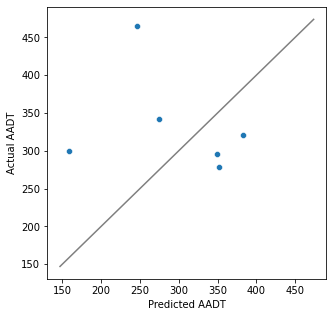

Area bristol


ValueError: not enough values to unpack (expected 3, got 0)

In [31]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AADT_sat_results_train[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_train, avg_flow_preds_train)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count metrics for local training')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

In [9]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_local = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol", "manchester"]
for area in areas:
    print(area)
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    
    predictions_glocal = global_models[area]
    test_report = image_year_reports[area]
    
    time = times[area]
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AADT_sat_results[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, predictions_glocal)
    
    predictions_local = local_models[area]
    AADT_sat_results_local[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, predictions_local)

birmingham
cambridge
bristol
manchester


Area birmingham
0.0006811871352984389
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  8652.58 		 MSE: 5630.17 		 MSE: 4736.89
MAE:  79.32  		 MAE: 56.79 		 MAE: 54.81
MAPE: 0.36 		 MAPE: 0.17 		 MAPE 0.17
R^2:  0.82 		 R^2: 0.88 		 R^2: 0.9


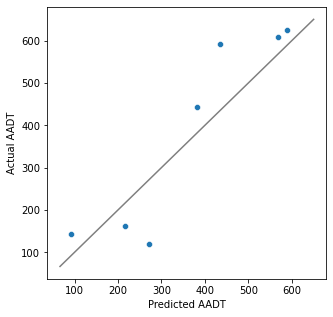

Area cambridge
0.0075991095028968975
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  14047.89 		 MSE: 588.38 		 MSE: 736.16
MAE:  102.61  		 MAE: 21.05 		 MAE: 23.13
MAPE: 0.3 		 MAPE: 0.07 		 MAPE 0.07
R^2:  -2.66 		 R^2: 0.85 		 R^2: 0.81


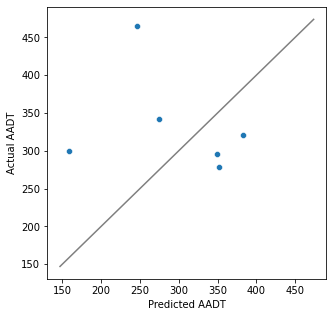

Area bristol
0.002575734811561592
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  62235.37 		 MSE: 25227.59 		 MSE: 25663.63
MAE:  233.04  		 MAE: 140.99 		 MAE: 142.02
MAPE: 0.61 		 MAPE: 0.37 		 MAPE 0.37
R^2:  -11.68 		 R^2: -4.14 		 R^2: -4.23


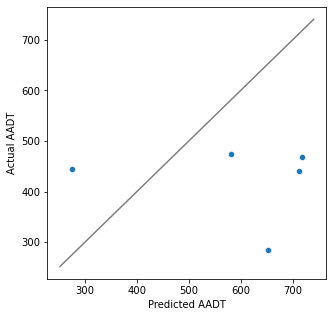

Area manchester
0.006173242642977528
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  71254.58 		 MSE: 33099.08 		 MSE: 34456.64
MAE:  247.43  		 MAE: 171.15 		 MAE: 174.96
MAPE: 0.41 		 MAPE: 0.29 		 MAPE 0.29
R^2:  -2.02 		 R^2: -0.4 		 R^2: -0.46


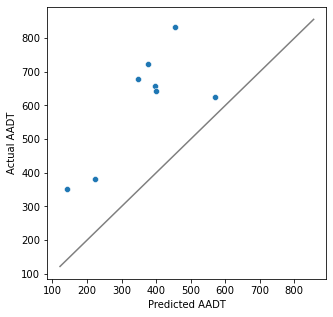

In [10]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_local, avg_flow_preds_local, avg_flow_preds_sat_local = AADT_sat_results_local[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_local, avg_flow_preds_local)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print(mape_gl - mape_g)
    
    print('Satellite Metrics \t Gold count metrics \t Gold count metrics for local training')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

In [12]:
test_report

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
0,M602/6029B,1563,2019-01-01T00:00:00,00:14:00,0,84,35,3,3,64,125,2019-01-01 00:14:00,0.362339,0.301475,0.113254,0.198805,0.320923
1,M602/6029B,1563,2019-01-01T00:00:00,00:29:00,1,101,73,2,0,66,176,2019-01-01 00:29:00,0.435669,0.628790,0.075503,0.000000,0.451859
2,M602/6029B,1563,2019-01-01T00:00:00,00:44:00,2,172,72,1,1,64,246,2019-01-01 00:44:00,0.741932,0.620176,0.037751,0.066268,0.631576
3,M602/6029B,1563,2019-01-01T00:00:00,00:59:00,3,214,83,0,1,65,298,2019-01-01 00:59:00,0.923101,0.714926,0.000000,0.066268,0.765080
4,M602/6029B,1563,2019-01-01T00:00:00,01:14:00,4,242,141,3,1,64,387,2019-01-01 01:14:00,1.043881,1.214512,0.113254,0.066268,0.993576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177039,M60/9186M,17691,2019-12-31T00:00:00,22:59:00,91,26,8,4,1,51,39,2019-12-31 22:59:00,0.435991,0.504061,0.544666,0.252456,0.449242
2177040,M60/9186M,17691,2019-12-31T00:00:00,23:14:00,92,23,6,1,0,51,30,2019-12-31 23:14:00,0.385684,0.378046,0.136166,0.000000,0.345571
2177041,M60/9186M,17691,2019-12-31T00:00:00,23:29:00,93,27,10,1,0,51,38,2019-12-31 23:29:00,0.452759,0.630076,0.136166,0.000000,0.437723
2177042,M60/9186M,17691,2019-12-31T00:00:00,23:44:00,94,22,1,0,0,50,23,2019-12-31 23:44:00,0.368915,0.063008,0.000000,0.000000,0.264937
